## Dyna planning

#### Background

The aim of this part of the assignment is to introduce you to the concept of Dyna (Sutton, 1990). By now you will have heard about model-free (MF) and model-based (MB) approaches to control. MF algorithms learn and store estimates of the state-action value function. This means that control simply involves retrieving those cached value estimates and choosing among the available actions by comparing their worth. MB control, on the other hand, involves the use of a model to calculate those values. In the RL literature this is typically known as planning. Planning has the advantage of affording behavioural flexibility, since once a change in the world is discovered the model can be updated and the values re-calculated in a way that reflects the global knowledge of the environment. By contrast, MF algorithms need many experiences to propagate the information about the change to other states.

Dyna (Sutton, 1990) is an integrated architecture which combines the merits of MF and MB approaches. Whilst interacting with the environment (i.e., being online), Dyna learns MF state-action values as well as a model of its environment (in the most general sense this involves both the transition and reward models). Whilst not interacting with the environment (i.e., being offline -- this can be in between consecutive moves or episodes, or during the equivalent of sleep in animals), Dyna uses its learnt model to additinally train the MF values. That is, the model now acts as a simulator of the environment and provides additional experiences for learning. This means that at decision time Dyna is fast to react, since it acts according to an MF policy by simply retrieving the relevant values; however, those values have been trained by a model and therefore contain some portion of the global knowledge of the environment collected so far.

One particularly critical aspect of learning is exploration, and in fact Dyna's original motivation was to improve the efficiency of exploration. You are invited to read the original paper by Sutton (1990) to familiarise yourself with the idea and the sort of problems it attempts to solve. The pdf of the paper can be found in the `papers` folder of this repository.

#### Task 1 [10 marks]

The first part of the assignment is to reproduce some of the results from the original Dyna paper (Sutton, 1990). In particular, **your task is to generate and visualise data plotted in figure 6** in that paper. You can neglect Dyna-PI and only implement Dyna-$Q$- and Dyna-$Q$+.

To make your life a little easier, and to let you jump right into the more interesting stuff, you are provided with the environment simulator located in `environment.py`, as well as a blueprint of the main code for the agent. That is, you have access to the file `agent.py` where you will find the `DynaAgent` class. This class has a method called `simulate` with the main simulation loop already implemented.

**Your task is to fill in the missing implementation** in the `agent.py` file. Thus, you are tasked to complete the following functions:
- `_policy`. This is the typical $\pi(a\mid s)$ which specifies how the agent chooses actions in any given state
- `_update_qvals`. This is the $Q$-value update rule
- `_update_experience_buffer`. This updates the agent's experience buffer from which it then samples planning updates
- `_update_action_count`. This counts the number of moves elapsed since each action has last been attempted
- `_plan`. This is the function which lets the agent plan

Once that's done you can run the code below which will hopefully reproduce the figure

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from write_load import load_env
from agent import DynaAgent

In [2]:
# load environments
maze_conf_path = os.path.abspath(os.path.join(os.getcwd(), 'C:/Users/Arne.Gittel/Documents/Neuro Master/Neural Moddeling/Assay7', 'envs'))
maze1_conf = load_env(os.path.join(maze_conf_path, 'dyna1.txt'))  # maze with only the right path open
maze2_conf = load_env(os.path.join(maze_conf_path, 'dyna2.txt'))  # maze with both paths open


In [3]:
# initialise the agents
# note that alpha is the learning rate (instead of beta as in the paper)
dyna_qplus  = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0.001)
dyna_qminus = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0)
dyna_qwierd = DynaAgent(alpha=0.5, gamma=0.9, epsilon=1)

In [4]:
np.random.seed(2)
# run simulations
num_trials = 3000
num_runs   = 50
perf       = [np.zeros((num_runs, num_trials*2)), np.zeros((num_runs, num_trials*2)), np.zeros((num_runs, num_trials*2))]
agents     = [dyna_qplus, dyna_qminus, dyna_qwierd]

for idx_agent, agent in enumerate(agents):
    for idx_run in range(num_runs):
        agent.init_env(**maze1_conf)

        agent.simulate(num_trials=num_trials, reset_agent=True, num_planning_updates=10)
        # world change
        agent.init_env(**maze2_conf)
        agent.simulate(num_trials=num_trials, reset_agent=False, num_planning_updates=10)
        # save performance
        perf[idx_agent][idx_run, :] = agent.get_performace()
        if (idx_run+1)%10 == 0:
            print('done with run %u/%u'%(idx_run+1, num_runs))

# average cumulative reward
avg_perf_dyna_qplus  = np.mean(perf[0], axis=0)
avg_perf_dyna_qminus = np.mean(perf[1], axis=0)
avg_perf_dyna_qwierd = np.mean(perf[2], axis=0)

done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50
done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50
done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50


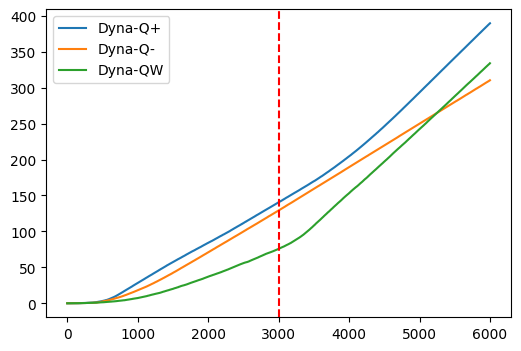

In [5]:
# plot Figure 6 from Sutton (1990) here
plt.figure(figsize=(6, 4))
plt.plot(avg_perf_dyna_qplus,  label='Dyna-Q+')
plt.plot(avg_perf_dyna_qminus, label='Dyna-Q-')
plt.plot(avg_perf_dyna_qwierd, label='Dyna-QW')

plt.axvline(3000, linestyle='--', c='r')
plt.legend()

Describe in your own words the apparent differences you observe in the above plot. Some of those differences involve the particular choice of the exploration bonus used in this algorithm. Suggest and implement another sensible exploration bonus and compare the performance of your agent against Dyna-$Q$+ and Dyna-$Q$-. Explain your choice. 

At first, both Dyna-Q+ and Dyna-Q- need around 600 timesteps to find the way in the maze that leads to the reward and can from here on out reliably maintain the route as seen in the nearly linear accumulation of reward over the time steps. Since Dyna-Q+ explores more it finds the reward faster but the slope of the cummulative reward over time is not as steep as Dyna-Q- learning. After 3000 timesteps, the maze changes and a new faster route to the reward is revealed. The Dyna Q+ learning will find this route after ~900 further timesteps while DynaQ- learning is not flexible enaugh to realise that a shorter route with higher reward is available. Therefore, the cummulitive summ graph shows that Dyna-Q+ will reliably add the optimal reward (-exploration payoff) while Dyna-Q- just continues adding the already old and known reward. 

I implemented another exploration Bonus Dyna-QW that is scaling the exploration with the inverse of the sum over all action counts. I opted to scale exploration this way, because the sum of the action choices should reflect states that are not explored in recent steps. The higher the summ of the action counts, the more unexplored routs in the maze. I initially scaled with the sum but there learning did not work and I can not fully explain why the inverse works so mutch better. The resulting learning is not as consistent in the first part as Dyna-Q+ and Dyna-Q- but learns the new maze rules faster after the shift than Dyna-Q+ and has roughly the same slope in the cumulative reward in the second stage. 

## 2-step task

#### Background

The 2-step task is one of the most iconic RL tasks (Daw et al. 2011). It was designed to dissect the relative contributions of the MF and MB systems in human choices. There are multiple ways in which MB information can enter choice. For instance, as you will have seen in the case of Dyna, the MF values are additionally trained by the MB system during offline behavioural states. In fact, this process of Dyna-style planning parallels closely hippocampal replay which has been suggested to implement MB planning (Mattar \& Daw, 2018).

For the purpose of this exercise, we will assume that the choice is guided by a linear combination of the MF and MB values. Thus, by tweaking the relative contribution of each, you would expect different behaviours to emerge. Classically, the measure of this balance used in the 2-step task is stay probability. That is, the probability that the subject/agent repeats the same first-stage choice conditioned on the outcome of the second stage in the previous trial.

#### Task 2 [20 marks]

For this part of the assigniment, **your task is to reproduce and visualise data plotted in figure 2** in Daw et al. (2011). There is no pre-implemented code for the agent, except for some basics in the `agent.py` file where you can find the `TwoStepAgent` class. Therefore, you have to follow the methodology in the paper and implement it yourself. You can find the relevant paper in the `papers` folder of this git repository. The only provided code is the one below, as well as the `get_stay_probabilities` method.

In [6]:
from agent import TwoStepAgent

In [7]:
# initialise the agent. The parameters are taken from the paper
agent = TwoStepAgent(alpha1=0.54, alpha2=0.42, beta1=5.19, beta2=3.69, lam=0.57, w=0.39, p=0.11)

In [8]:
np.random.seed(2)
# run simulations
num_trials  = 201
num_averg   = 17
stay_probas = np.zeros((num_averg, 4))
for n in range(num_averg):
    agent.simulate(num_trials)
    stay_probas[n, :] = agent.get_stay_probabilities()

AttributeError: 'TwoStepAgent' object has no attribute '_init_q_values'

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(1, np.mean(stay_probas[:, 0]), facecolor='blue', label='common')
plt.bar(2, np.mean(stay_probas[:, 1]), facecolor='red', label='rare')
plt.bar(3, np.mean(stay_probas[:, 2]), facecolor='blue')
plt.bar(4, np.mean(stay_probas[:, 3]), facecolor='red')
plt.ylim(0.5, 1)
plt.xticks([1.5, 3.5], ['rewarded', 'unrewarded'])
plt.legend()

Describe in your own words the apparent differences between the MF and MB agents. What do the data plotted with best-fitting parameters tell you about the relative contributions of MF and MB systems to subjects' choices?

I could not solve task II coding part. In the graphes from the paper the reinforcement learning (MF) the fact that for the choices which resulted in a rare or common outcome, the state (rare vs. common) had no effect on the probability of the choice to be choosen again, only the achieved reward at the end impactet the probability to be choosen again. In the model based approach (MB) a choice with the common outcome that was rewarded had had a higher probability to be choosen again than a choice with a rare outcome that was rewarded, tho in the case of an absence of reward choices with common outcomes were more inhibited to be chosen again while choices with rare outcomes were still choosen more frequently even if they yielded no reward in the past. In human data, it seems that both model free and model based learning are combined. The general difference between the higher probability in rewarded choices compared to the unrewarded choices can be seen similar to the model free learning, additionally the difference in rewarded and unrewarded cases between the rare and common outcomes of a choices seems to be implemented as well so that choices in common case have a higher probability to be choosen again when recieving a reward compared to the rare case and vise versa when the choice yielded no reward if the outcome was the common case, the probability to be choosen again was low but if it was the rare outcome the probability to be choosen again is still high. 